# Biomass burning emissions files perturb and save
Import emissions and calculate monthly sum and average over 2005-2015. Save as new emissions files in loop

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from matplotlib import rcParams
import pandas as pd
import cftime
import glob
import os
import nc_time_axis
from datetime import datetime

In [2]:
rcParams['font.size'] = 20

#make (today's) date label for filename
datelabel = datetime.today().strftime('%Y%m%d')

In [3]:
#define file locations
file_loc1 = '/div/no-backup/users/zofias/CMIP6_bb_ems/' #infile path
out_file = '/div/nac/users/zofias/inputdata/crices_bb_ems/' #path for saving netcdfs

#resolution label
reslab = '0.9x1.25'

#### Select files

In [4]:
bb_files = sorted(glob.glob(f'{file_loc1}*.nc'))

In [ ]:
# check filelist
bb_files

In [9]:
# check filename label and adjust if incorrect
# should be e.g. emissions-cmip6_CO_bb_surface
for file in bb_files:
    filelab = file.split('/')[-1][:-32]
    print(filelab)



emissions-cmip6_CO_bb_surface
emissions-cmip6_DMS_bb_surface
emissions-cmip6_SO2_bb_surface
emissions-cmip6_SOAGx1.5_bb_surface
emissions-cmip6_bc_a4_bb_surface
emissions-cmip6_num_bc_a4_bb_surface
emissions-cmip6_num_pom_a4_bb_surface
emissions-cmip6_num_so4_a1_bb_surface
emissions-cmip6_pom_a4_bb_surface
emissions-cmip6_so4_a1_bb_surface


In [7]:
for file in bb_files:
    filelab = file.split('/')[-1][:-32]

    #open file and select years 2005-2014
    bb_ems_all = xr.open_dataset(file).sel(time=slice('2005-01-01','2015-01-01'))

    #all vars in dataset
    vars = list(bb_ems_all.keys())
    #var label (second variable in dataset)
    ems_var = vars[1]

    # #select 2010 dates to use in netcdf
    ems_bb_2010 = bb_ems_all.sel(time=slice('2010-01-01','2010-12-30'))

    #Find lat and lon indices
    #where 50N, 60N latitude index is
    lat_ind_50 = np.where(bb_ems_all.lat>=50)[0][0] 
    lat_ind_60 = np.where(bb_ems_all.lat>=60)[0][0] 

    #where 191 longitude is (Bering sea), where -24 is (greenland and iceland)
    lon_191 = np.where(bb_ems_all.lon>=191)[0][0] 
    lon_336 = np.where(bb_ems_all.lon>=336)[0][0]

    #calculate sum and average emissions for 2005 - 2015
    emiss_calcs = xr.Dataset() 
    emiss_calcs['bb_average'] = bb_ems_all[ems_var].groupby('time.month').mean(dim='time',keep_attrs=True)
    emiss_calcs['bb_sum'] = bb_ems_all[ems_var].groupby('time.month').sum(dim='time',keep_attrs=True)

    #perturbation file, sum over >50N
    emiss_calcs['bb_ems_pert'] = emiss_calcs['bb_average'].copy()
    emiss_calcs['bb_ems_pert'][:,lat_ind_60:,:] = emiss_calcs['bb_sum'][:,lat_ind_60:,:].values
    emiss_calcs['bb_ems_pert'][:,lat_ind_50:,lon_191:lon_336] = emiss_calcs['bb_sum'][:,lat_ind_50:,lon_191:lon_336].values 

    #correct time coordinates
    emiss_calcs = emiss_calcs.rename({'month':'time'})
    emiss_calcs = emiss_calcs.assign_coords({'time':ems_bb_2010.time})

    #make copies of dataset for 2010 only to get times and dates correct
    ds_bb_mean = ems_bb_2010.copy(deep=True)
    ds_bb_pert = ems_bb_2010.copy(deep=True)

    #make perturbation file base on mean baseline
    ds_bb_mean[ems_var] = emiss_calcs['bb_average']
    ds_bb_pert[ems_var] = emiss_calcs['bb_ems_pert']

    #save to netcdf
    #ds_bb_mean.to_netcdf(f'{out_file}{filelab}_2010_{reslab}_mean_{datelabel}.nc')
    #ds_bb_pert.to_netcdf(f'{out_file}{filelab}_2010_{reslab}_pert_50N_60N_{datelabel}.nc')

## Smaller regional perturbations

In [7]:
baseline_files = sorted(glob.glob(f'{out_file}*mean*.nc'))

In [21]:
for file in bb_files:
    filelab = file.split('/')[-1][:-32]

    #open file and select years 2005-2014
    bb_ems_all = xr.open_dataset(file).sel(time=slice('2005-01-01','2015-01-01'))

    #all vars in dataset
    vars = list(bb_ems_all.keys())
    #var label (second variable in dataset)
    ems_var = vars[1]

    # #select 2010 dates to use in netcdf
    ems_bb_2010 = bb_ems_all.sel(time=slice('2010-01-01','2010-12-30'))

    #Find lat and lon indices
    #where 50N, 60N latitude index is
    lat_ind_50 = np.where(bb_ems_all.lat>=50)[0][0] 
    lat_ind_60 = np.where(bb_ems_all.lat>=60)[0][0] 

    #where 191 longitude is (Bering sea), where -24 is (greenland and iceland)
    lon_191 = np.where(bb_ems_all.lon>=191)[0][0] 
    lon_336 = np.where(bb_ems_all.lon>=336)[0][0]
    lon_94 = np.where(bb_ems_all.lon>=94)[0][0] 
    lon_224 = np.where(bb_ems_all.lon>=224)[0][0] 

    #calculate sum and average emissions for 2005 - 2014
    emiss_calcs = xr.Dataset() 
    emiss_calcs['bb_average'] = bb_ems_all[ems_var].groupby('time.month').mean(dim='time',keep_attrs=True)
    emiss_calcs['bb_sum'] = bb_ems_all[ems_var].groupby('time.month').sum(dim='time',keep_attrs=True)

    #perturbation file, sum over >50N
    emiss_calcs['bb_ems_pert'] = emiss_calcs['bb_average'].copy()
    #emiss_calcs['bb_ems_pert'][:,lat_ind_60:,lon_94:lon_191] = emiss_calcs['bb_sum'][:,lat_ind_60:,lon_94:lon_191].values #East BOAS
    emiss_calcs['bb_ems_pert'][:,lat_ind_50:,lon_224:lon_336] = emiss_calcs['bb_sum'][:,lat_ind_50:,lon_224:lon_336].values #East BONA

    #correct time coordinates
    emiss_calcs = emiss_calcs.rename({'month':'time'})
    emiss_calcs = emiss_calcs.assign_coords({'time':ems_bb_2010.time})

    #make copies of dataset for 2010 only to get times and dates correct
    ds_bb_mean = ems_bb_2010.copy(deep=True)
    ds_bb_pert = ems_bb_2010.copy(deep=True)

    #make perturbation file base on mean baseline
    ds_bb_mean[ems_var] = emiss_calcs['bb_average']
    ds_bb_pert[ems_var] = emiss_calcs['bb_ems_pert']

    #save to netcdf
    #ds_bb_mean.to_netcdf(f'{out_file}{filelab}_2010_{reslab}_mean_{datelabel}.nc')
    ds_bb_pert.to_netcdf(f'{out_file}{filelab}_2010_{reslab}_EastBONA_{datelabel}.nc')

In [18]:
lon_94

76

## Plot emissions

Text(0.5, 0.97, 'BC a4 biomass burning emissions (average 2005-2015)')

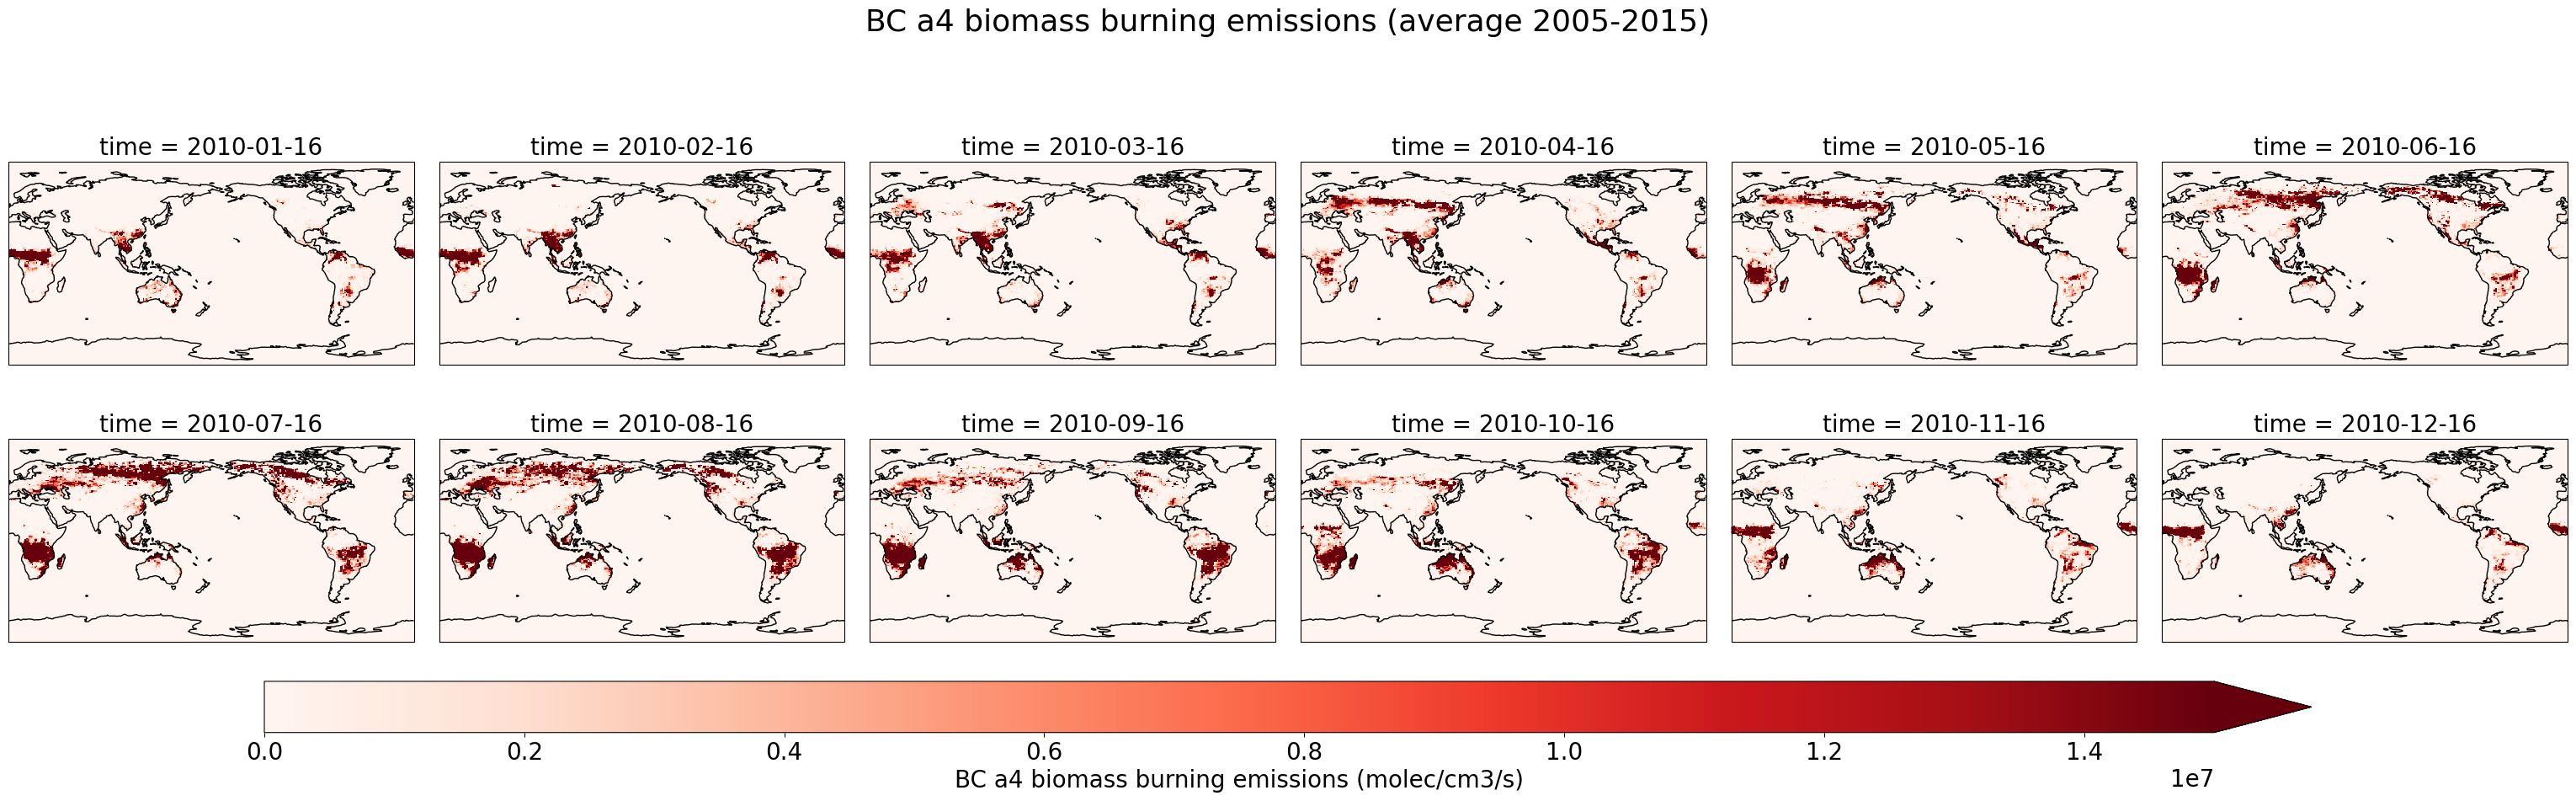

In [14]:
fg = ds_bb_mean.emiss_bb.plot(size=5,
    col="time",
    col_wrap=6,
    cmap="Reds",
    vmax=1.5e7,
    #vmin=220,
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.05,"label":"BC a4 biomass burning emissions (molec/cm3/s)"},
    robust=True,
)
fg.map(lambda: plt.gca().coastlines())
fg.fig.suptitle('BC a4 biomass burning emissions (average 2005-2015)',y=0.97,fontsize=26)

Text(0.5, 0.97, 'BC a4 biomass burning emissions (pert 2005-2015)')

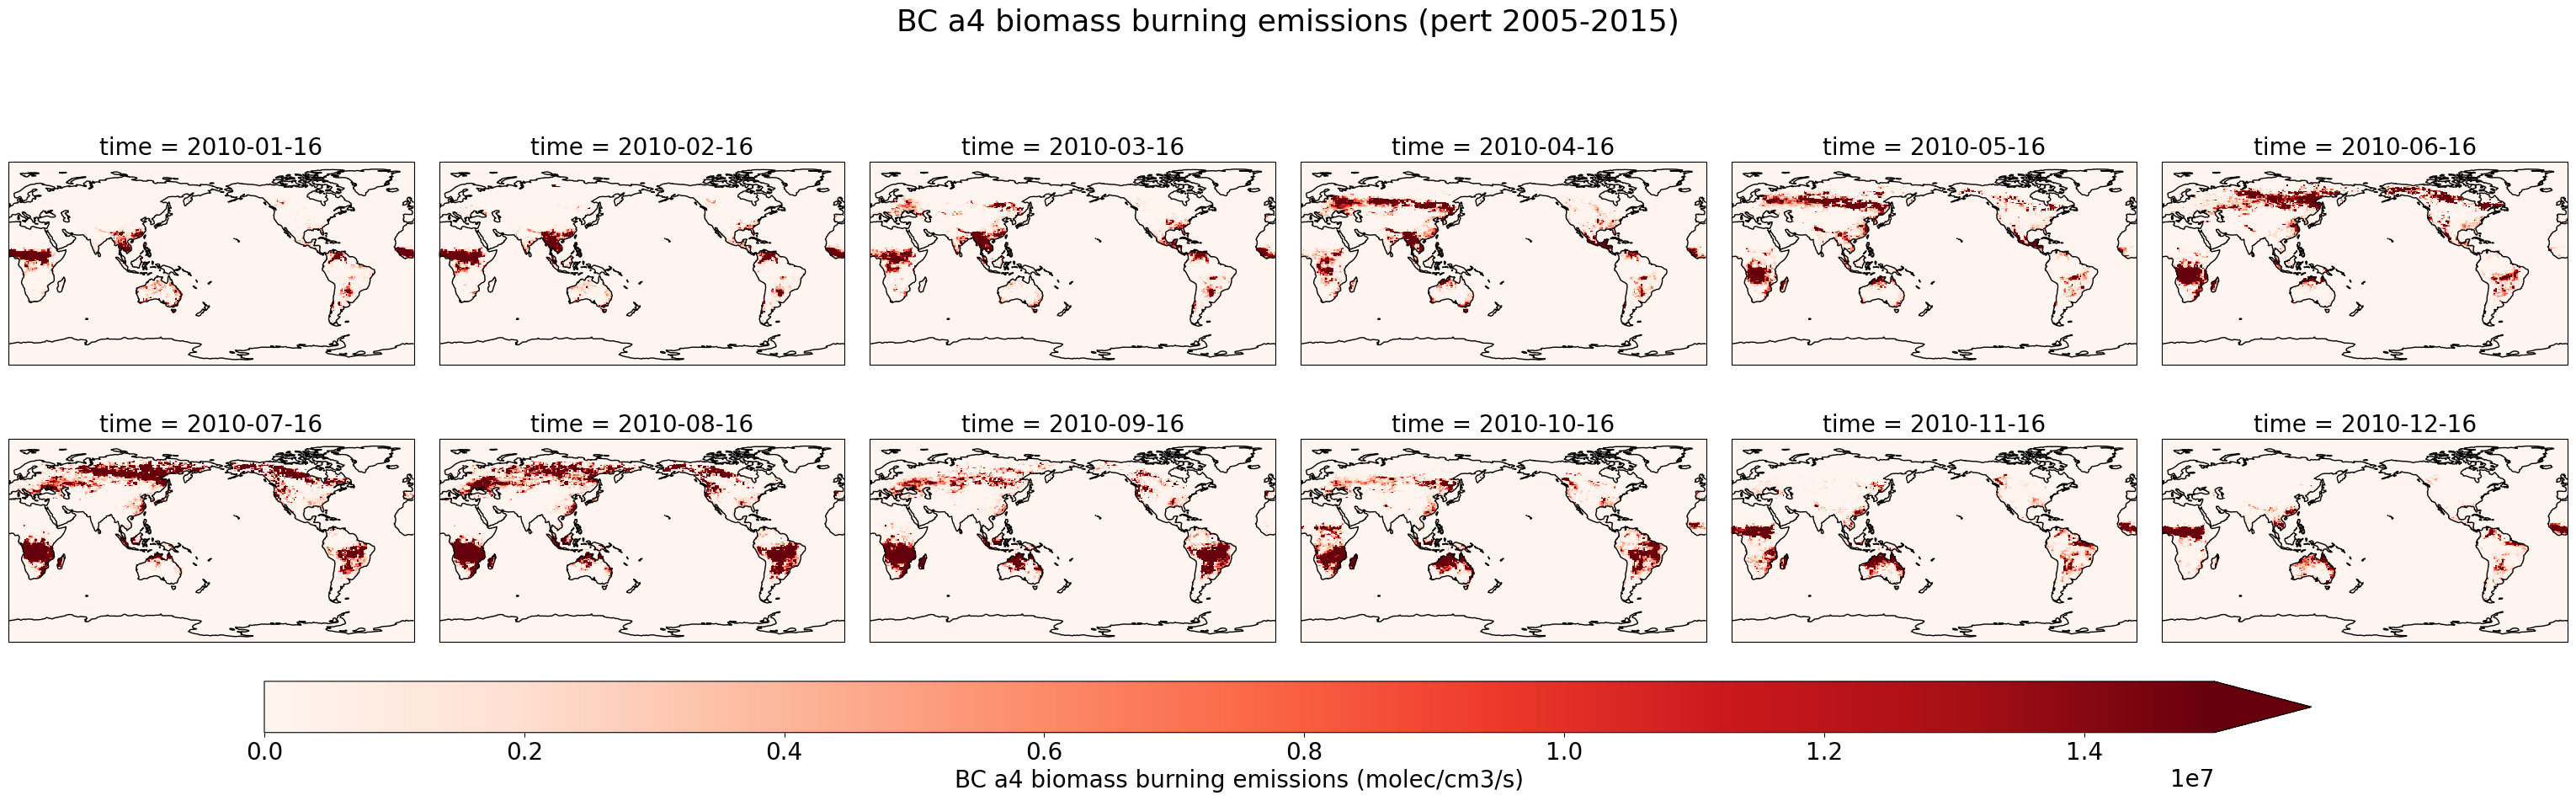

In [15]:
fg = ds_bb_pert.emiss_bb.plot(size=5,
    col="time",
    col_wrap=6,
    cmap="Reds",
    vmax=1.5e7,
    #vmin=220,
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.05,"label":"BC a4 biomass burning emissions (molec/cm3/s)"},
    robust=True,
)
fg.map(lambda: plt.gca().coastlines())
fg.fig.suptitle('BC a4 biomass burning emissions (pert 2005-2015)',y=0.97,fontsize=26)

## Emissions difference

In [16]:
diff = ds_bb_pert - ds_bb_mean

Text(0.5, 0.97, 'BC a4 biomass burning emissions perturbed >50N diff  (2005-2015)')

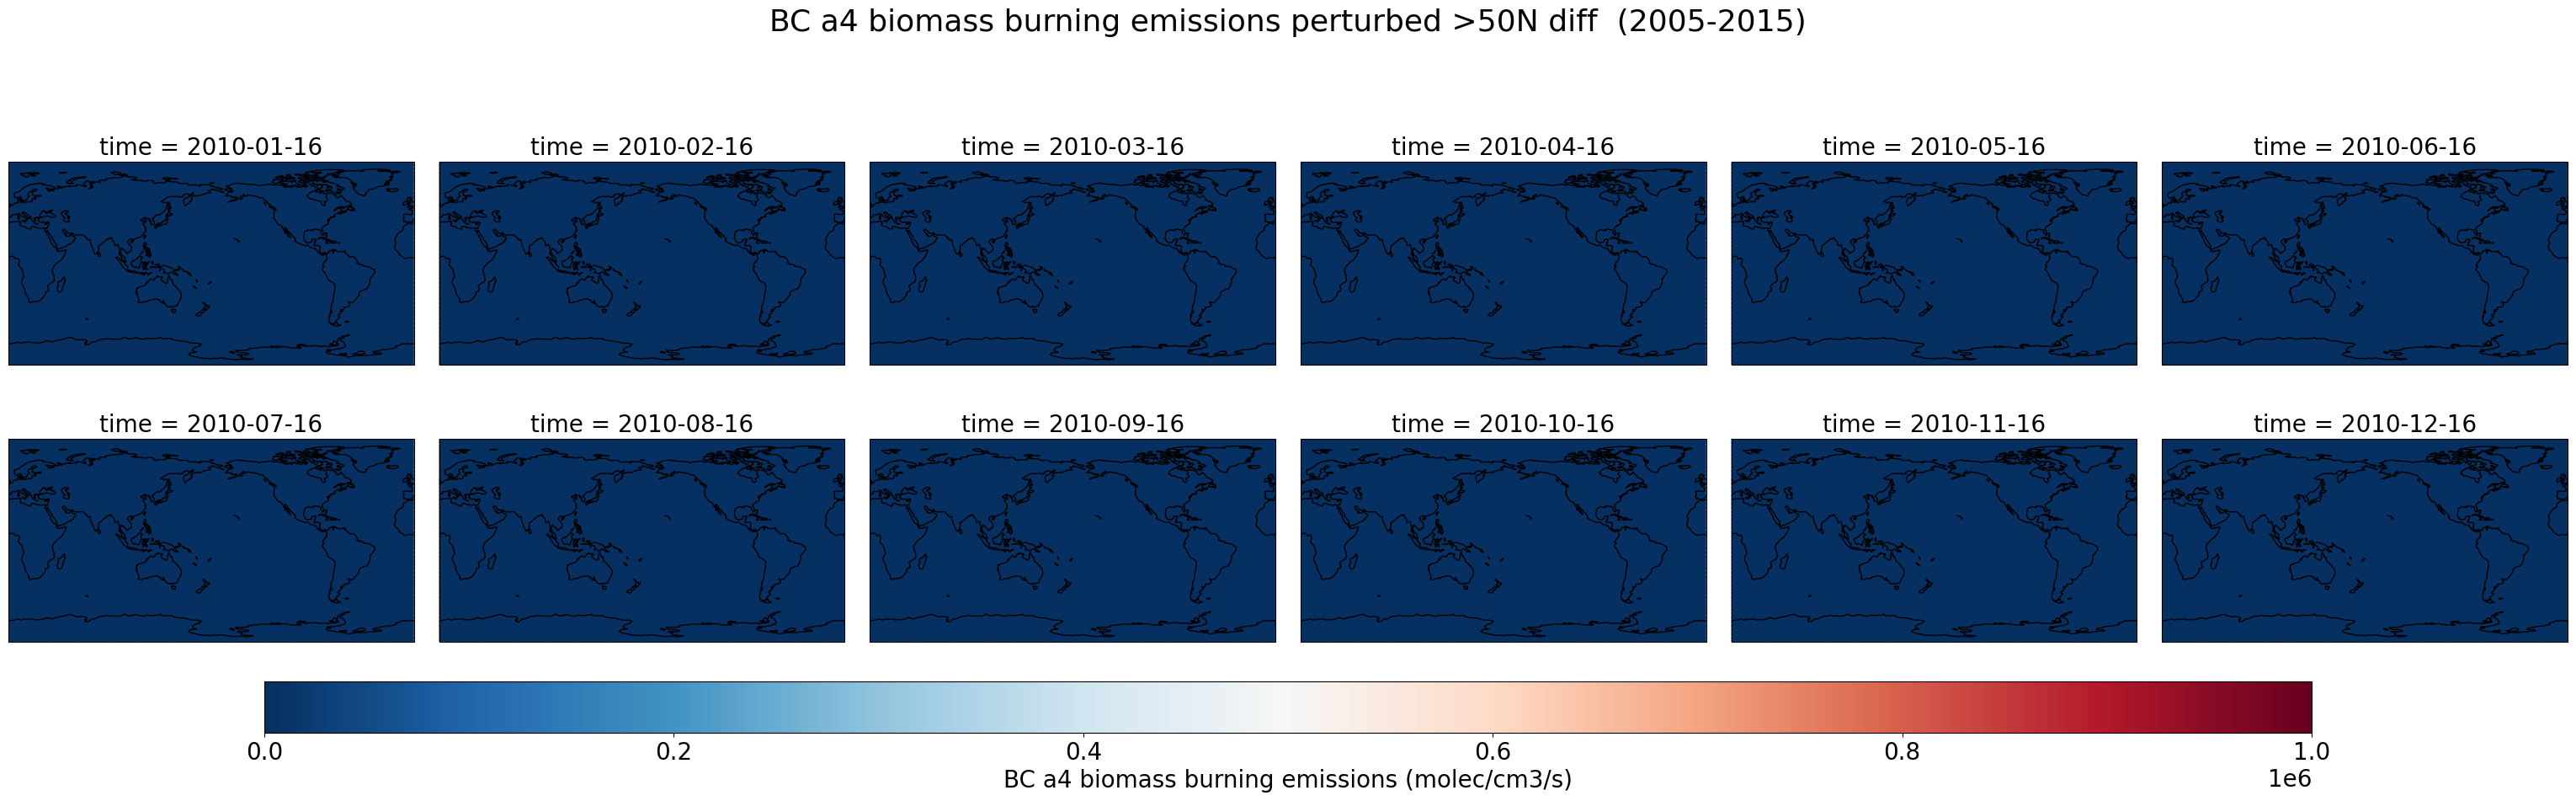

In [17]:
fg = diff.emiss_bb.plot(size=5,
    col="time",
    col_wrap=6,
    cmap="RdBu_r",
    vmax=1e6,
    #vmin=220,
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.05,"label":"BC a4 biomass burning emissions (molec/cm3/s)"},
    robust=True,
)
fg.map(lambda: plt.gca().coastlines())
fg.fig.suptitle('BC a4 biomass burning emissions perturbed >50N diff  (2005-2015)',y=0.97,fontsize=26)